# DeepGaze II

This notebook demonstrates how to load and use the DeepGaze II model. It needs to be run using python3 and an up to date tensor flow installation (I use tensorflow 1.1, but tensorflow 1.0 might work, too). Using a GPU will considerably speed up computation

In [1]:
%matplotlib inline

In [2]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns
sns.set_style('white')

/usr/local/lib/python3.4/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
import tensorflow as tf

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1313: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


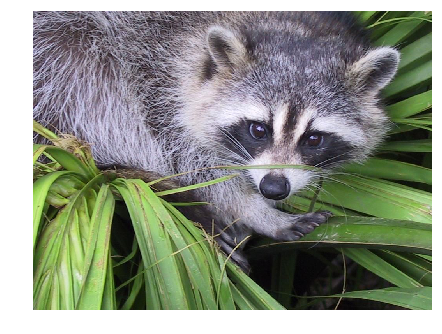

In [7]:
# our example image for which we will calculate DeepGaze predictions

from scipy.misc import face
img = face()

plt.imshow(img)
plt.axis('off');

The model expects all input as 4d tensors of shape `BHWC` (i.e. batch-height-width-channel). It takes two inputs:
A batch of images and a batch of centerbias log densities. Here we create the input data to process one image with a uniform center bias.

In [8]:
image_data = img[np.newaxis, :, :, :]  # BHWC, three channels (RGB)
centerbias_data = np.zeros((1, img.shape[0], img.shape[1], 1))  # BHWC, 1 channel (log density)

Now we import the deep gaze model from the tensorflow meta-graph file

In [9]:
tf.reset_default_graph()

In [11]:
new_saver = tf.train.import_meta_graph('deep_gaze2_experiment0010.ckpt.meta')

input_tensor = tf.get_collection('input_tensor')[0]
centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
log_density = tf.get_collection('log_density')[0]
log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]

And finally we create a tensorflow session, restore the model parameters from the checkpoint and compute the log density prediction for out input data:

In [14]:
with tf.Session() as sess:
    
    new_saver.restore(sess, 'deep_gaze2_experiment0010.ckpt')
    
    log_density_prediction = sess.run(log_density, {
        input_tensor: image_data,
        centerbias_tensor: centerbias_data,
    })

INFO:tensorflow:Restoring parameters from deep_gaze2_experiment0010.ckpt


The log density predictions again are of shape `BHWC`. Since the log-densities are just 2d, `C=1`. And since we processed only one image, `B=1`:

In [15]:
print(log_density_prediction.shape)

(1, 768, 1024, 1)


Finally, we can visualize the model prediction. This is how the log density looks like:

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1313: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


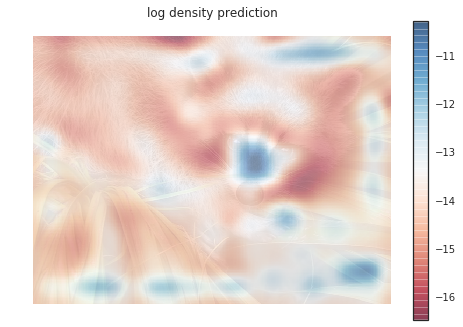

In [16]:
plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow((log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('log density prediction')
plt.axis('off');

And this is how the corresponding density looks like

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1313: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


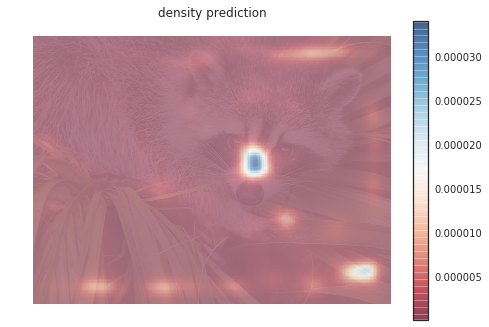

In [17]:
plt.gca().imshow(img, alpha=0.2)
m = plt.gca().matshow(np.exp(log_density_prediction[0, :, :, 0]), alpha=0.5, cmap=plt.cm.RdBu)
plt.colorbar(m)
plt.title('density prediction')
plt.axis('off');